#  Introduction



## why this is important

Gastrointestinal stromal tumors (GISTs) are the most common mesenchymal neoplasms of the gastrointestinal tract. The patient normally received surgery to remove the main tumor followed by chemotherapy. There are currently three major types of chemotherapy for GIST patient, imatinib, sunitinib, and regorafenib. Patient who failed imatinib will be given sunitinib, while regorafenib is the last line of treatment. Although all patients were subjected to standard chemotherapy, their clinical outcome is highly unpredictable. If we know who will have a cancer-free life and how has high risk of cancer-death, we can give the high-risk patient a higher dose of chemotherapy to increase their chance to live.

![gist](gist.jpg "Title")



I hypothesize that different patient charaters will be associated with patient’s response to these drugs and thier overall survival. In this project, I propose to design a machine learning algorithm to predict patient's risk of dying from GIST. 

The Life Raft Group (LRG) is a patient advocate organization for GIST patients. It has the world largest GIST patient registry database, including over 1,800 patient records and over 450 data fields. I will interrogate this LRG database and use retrospective analysis to extract  important independent variables. In this research project, we will use cross-validation to train the entire cohort and classify patients into "High Risk" and "Low Risk" groups. As a outcome for this project, we will add a note on the database website. When patients and oncologists login in, they will see a note saying "High risk" or "Low risk". 

# Let us see the data-Criteria: Downloaded the data correctly

The Life Raft Group(LRG) patient registry is the largest GIST patient database with more than 1800 cases. The patient-reported registry contains patient clinical record from 2000 to 2018.  It includes 450 different variables, including general information (ethic, age, gender, etc.), pathology report (tumor size, stage, metastasis), medication record (which of the three drugs has been used, dose), and follow-up prognosis (over all survival, progression free survival).

## First, we import all the packages

In [1]:
# load all packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from random import randint
import sys
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
sys.path.append('./KaggleAux') 
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind, ttest_ind_from_stats
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

C:\Users\ywang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Import the LRG registry data

In [4]:
#load LRG data for who have died
LRG = pd.read_csv("LRGPhaseII.csv") 
LRG.head()

,PatientID,MaritalStatus,DateOfDeath,Cancerdeath,AgeAtDiagnosis,DateOfDiagnosis,CurrentAge,OSFromDiagnosis(yrs),OS_Status,YearJoinedRegistry,...,Progression in 1M?,Progression in 2nd line?,RFS_Time(yrs),RFS_Status,Time:DiagToMutTest,Had Adjuvant?,LastTreatmentLine,NIHrisk,TumorSize,MitRate
0,389,Married,9/10/2002,1,45.9,5/15/2000,48.0,2.321697,1,2004,...,No,No,0.002738,1,3000.0,No,0.0,Unknown,0.0,NaN
1,872,Married,NaN,0,31.8,9/19/2007,41.0,1.935661,0,2007,...,No,No,0.005476,0,3000.0,Yes,1.3,High risk,14.0,NaN
2,1213,Married,NaN,0,54.3,3/16/2010,61.0,0.010951,0,2010,...,No,No,0.010951,0,3000.0,No,0.0,High risk,5.0,NaN
3,1102,Married,3/8/2011,0,68.3,6/24/2008,71.0,2.702259,1,2009,...,Yes,No,0.024641,1,3000.0,No,1.7,Unknown,0.0,NaN
4,1272,Married,NaN,0,54.6,8/14/2010,61.0,0.027379,0,2010,...,No,No,0.035592,0,3000.0,No,0.0,Unknown,0.5,NaN


## Remove some of the distractive fields

In [5]:
# Let us remove some useless fields, especially the one in date format since we have calculated the date difference
LRG = LRG.drop('DateOfDeath',1 )

# ID is not a realistic preditable variable
LRG = LRG.drop('PatientID',1 )
# We will drop the date field since the future patient will not have diagnose year of past
LRG = LRG.drop('DateOfDiagnosis',1 )

# Similarly, future member cannot resigter in the past year
LRG = LRG.drop('DateJoinedRegistry',1 )

#since OSFromDiagnosis(yrs) tells us how long patient live, it is not a predict factor, but a outcome
# we should remove it
LRG = LRG.drop('OSFromDiagnosis(yrs)',1 )

In [6]:
LRG.describe()

,Cancerdeath,AgeAtDiagnosis,CurrentAge,OS_Status,YearJoinedRegistry,GISTType,Mutation test,Exon,EverHadSunitinib?,EveryHadRegorafenib?,EverHadNilotinib?,EverHadSorafenib?,SDH category,Initialdiagnosis,RFS_Time(yrs),RFS_Status,Time:DiagToMutTest,LastTreatmentLine,TumorSize,MitRate
count,1218.000000,1218.000000,1213.000000,1218.000000,1218.000000,1218.000000,1218.000000,452.000000,1218.00000,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1217.000000,1218.000000,1218.000000,505.000000
mean,0.241379,50.939655,59.987634,0.302956,2007.991790,2.969622,0.433498,11.495575,0.23399,0.053366,0.057471,0.060755,6.083744,1.023810,4.420020,0.518062,1858.533213,1.778489,6.537882,17.160396
std,0.428096,14.262288,13.449785,0.459725,4.034151,0.265638,0.495761,2.251873,0.42354,0.224855,0.232836,0.238979,1.201019,0.177422,4.034894,0.499879,1437.632405,1.698643,6.585759,32.197940
min,0.000000,0.000000,15.000000,0.000000,2001.000000,0.000000,0.000000,9.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.002738,0.000000,0.030000,0.000000,0.000000,0.500000
25%,0.000000,43.000000,52.000000,0.000000,2004.000000,3.000000,0.000000,11.000000,0.00000,0.000000,0.000000,0.000000,6.000000,1.000000,1.333333,0.000000,52.630000,1.300000,0.000000,3.000000
50%,0.000000,52.100000,61.000000,0.000000,2008.000000,3.000000,0.000000,11.000000,0.00000,0.000000,0.000000,0.000000,6.000000,1.000000,3.293634,1.000000,3000.000000,1.700000,5.000000,7.000000
75%,0.000000,60.900000,69.000000,1.000000,2011.000000,3.000000,1.000000,11.000000,0.00000,0.000000,0.000000,0.000000,7.000000,1.000000,6.171116,1.000000,3000.000000,2.000000,10.000000,19.000000
max,1.000000,92.200000,93.000000,1.000000,2017.000000,4.000000,1.000000,18.000000,1.00000,1.000000,1.000000,1.000000,7.000000,2.000000,30.715948,1.000000,3000.000000,20.000000,42.000000,360.000000


# Clean the data and handle the missing data

In [7]:
#let's see what are missing
LRG.isnull().sum()

MaritalStatus                 0
Cancerdeath                   0
AgeAtDiagnosis                0
CurrentAge                    5
OS_Status                     0
YearJoinedRegistry            0
Gender                        0
GISTType                      0
Mutation test                 0
Mutation                      0
Gene                          0
Exon                        766
Race                          0
CountryOfBirth                2
CountryOfResidence            3
PrimaryTumorlocation          0
PresentationCalc              0
EverHadSunitinib?             0
EveryHadRegorafenib?          0
EverHadNilotinib?             0
EverHadSorafenib?             0
SDH category                  0
Stomach?                      0
SDH+Wildtype                  0
Initialdiagnosis              0
Progression in 1M?            0
Progression in 2nd line?      0
RFS_Time(yrs)                 0
RFS_Status                    0
Time:DiagToMutTest            1
Had Adjuvant?                 0
LastTrea

* It appears that many patients do no have exon information. It is becasue they either did not have mutation test or the test result came out negative. We will fill the missing cell as chromosom 0, which does not exsit. 


In [8]:
missing_exon = 0
LRG["Exon"].fillna(missing_exon, inplace=True) 

In [9]:
#We have a few patients without informatio about country of birth and current resident. 
#Since the majority of cases are from US, we can predic the missing resident is "US"
missing_country = "US"
LRG["CountryOfBirth"].fillna(missing_country, inplace=True) 
LRG["CountryOfResidence"].fillna(missing_country, inplace=True) 

In [10]:
# There are a few cases without age information. We will use median age to fill them in.
median_age = LRG["CurrentAge"].median()
LRG["CurrentAge"].fillna(median_age, inplace=True)

In [11]:
missing_mutationtest = 3000
LRG["Time:DiagToMutTest"].fillna(missing_mutationtest, inplace=True) 

In [12]:
missing_Mitrate=0
LRG["MitRate"].fillna(missing_Mitrate, inplace=True) 

In [13]:
#Let double check of everything is fullfilled 
LRG.isnull().sum()

MaritalStatus               0
Cancerdeath                 0
AgeAtDiagnosis              0
CurrentAge                  0
OS_Status                   0
YearJoinedRegistry          0
Gender                      0
GISTType                    0
Mutation test               0
Mutation                    0
Gene                        0
Exon                        0
Race                        0
CountryOfBirth              0
CountryOfResidence          0
PrimaryTumorlocation        0
PresentationCalc            0
EverHadSunitinib?           0
EveryHadRegorafenib?        0
EverHadNilotinib?           0
EverHadSorafenib?           0
SDH category                0
Stomach?                    0
SDH+Wildtype                0
Initialdiagnosis            0
Progression in 1M?          0
Progression in 2nd line?    0
RFS_Time(yrs)               0
RFS_Status                  0
Time:DiagToMutTest          0
Had Adjuvant?               0
LastTreatmentLine           0
NIHrisk                     0
TumorSize 

* Good. Note that MitRate (tumor growth rate) has so many missing value as paitent did not have the test done. I will discuss this later. 

# Visulize the data and have a better understanding for data distribution

## check the training cohort

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2AA9B2E80>,
      dtype=object)

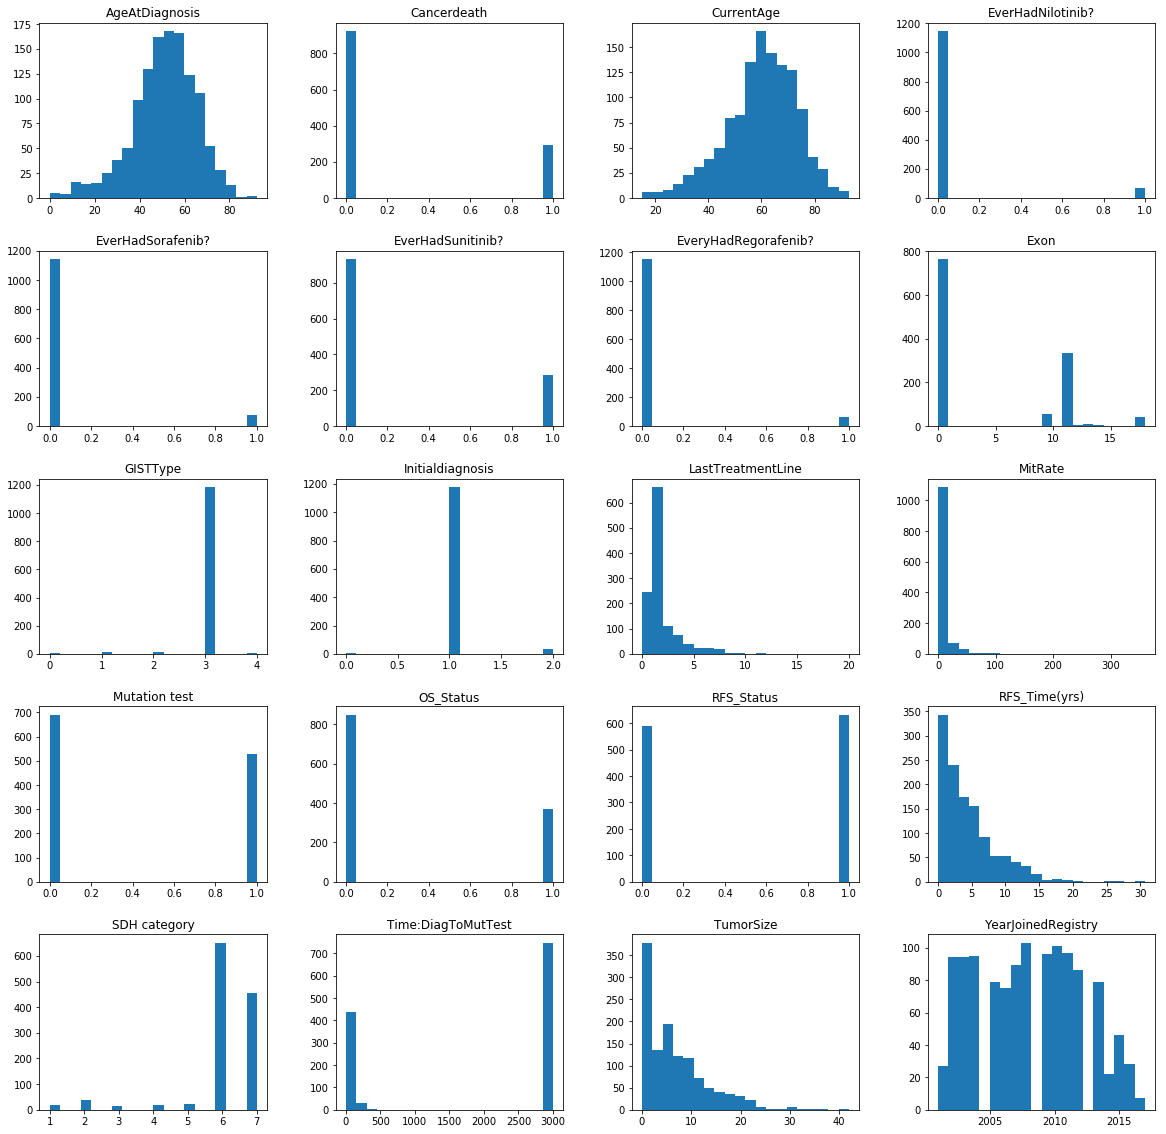

In [14]:
LRG.hist(bins=20,figsize=(20,20),grid=False)

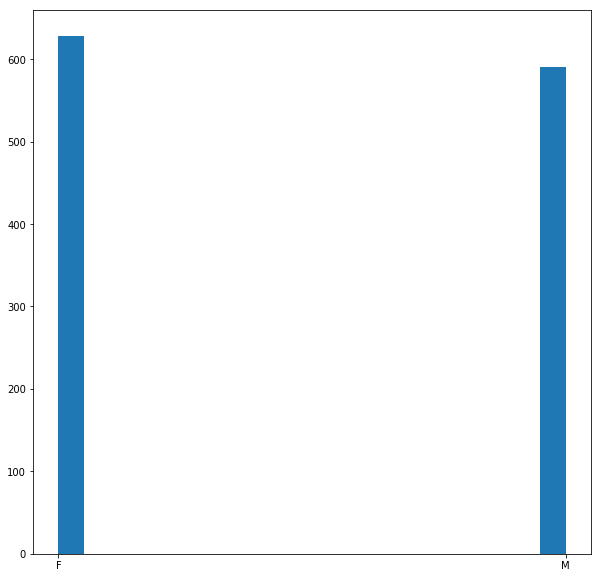

In [13]:
%matplotlib inline
LRG['Gender'].hist(bins=20,figsize=(10,10),grid=False)

Wait! the time from diagnose to mutation test has negative date range! These patient never had mutation test!
What happened is I delete all negative cells and use null?

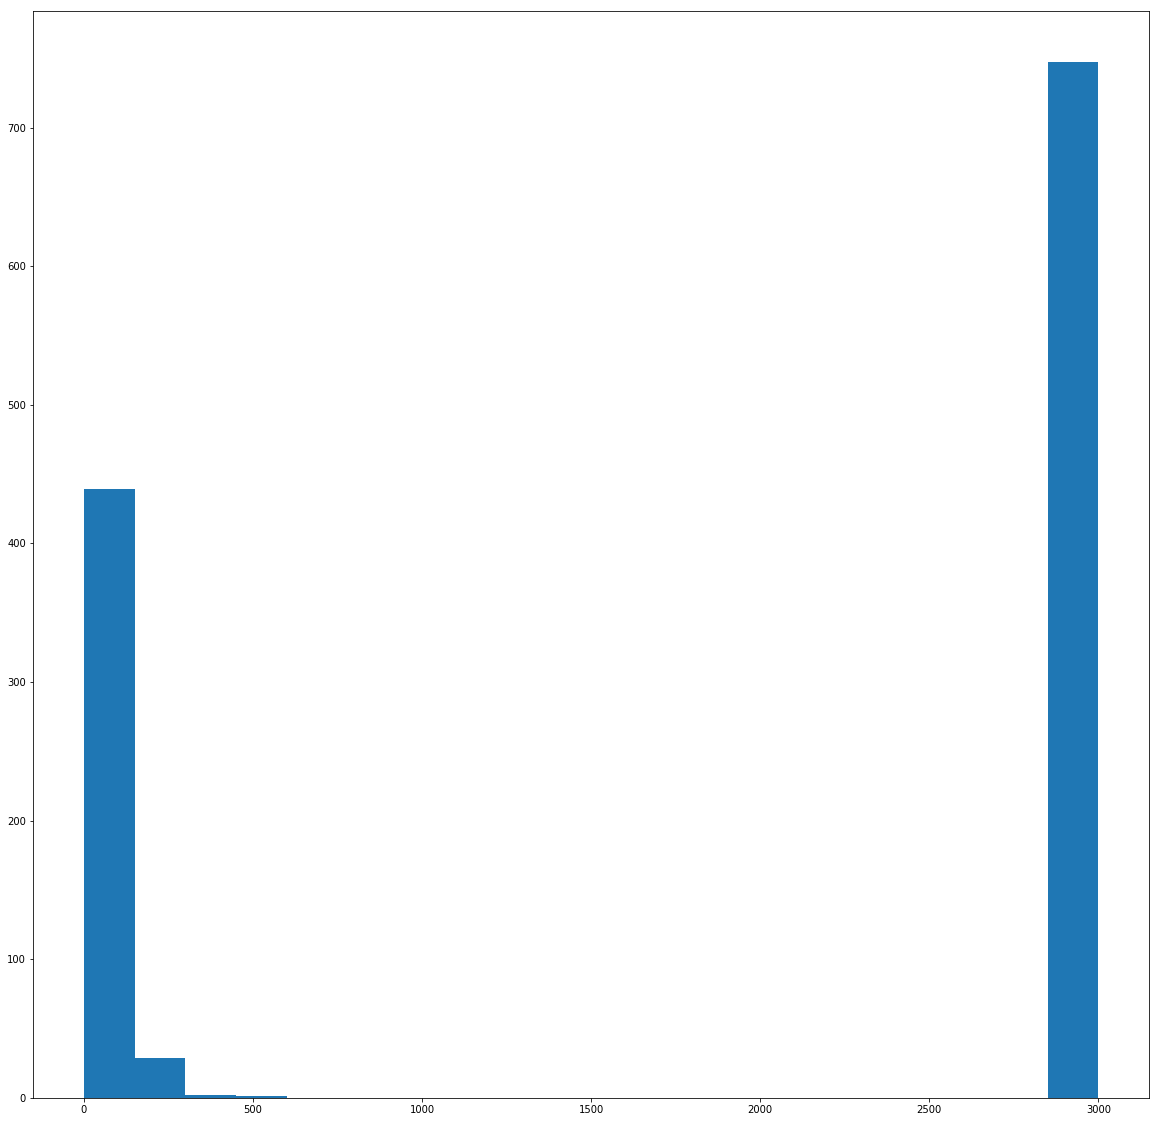

In [33]:
LRG['Time:DiagToMutTest'].hist(bins=20,figsize=(20,20),grid=False)

Text(0.5,1,'Survival Breakdown (1 = Died, 0 = Alive)')

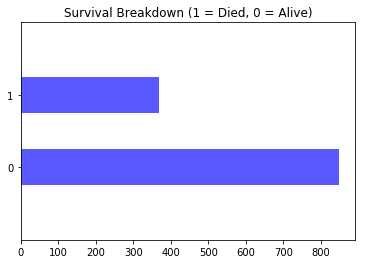

In [34]:
# Is death/alive case balanced?
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
LRG.OS_Status.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(LRG.OS_Status.value_counts())) 
plt.title("Survival Breakdown (1 = Died, 0 = Alive)")

Text(0.5,1,'Age Distribution within outcome')

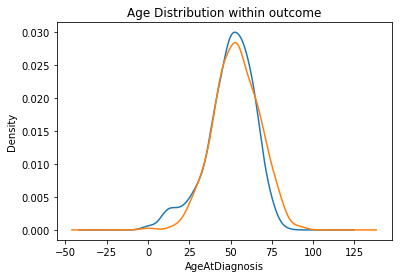

In [35]:
# plots patient age upon diagnosis vs cancer death
LRG.AgeAtDiagnosis[LRG.OS_Status == 0].plot(kind='kde')    
LRG.AgeAtDiagnosis[LRG.OS_Status == 1].plot(kind='kde')
 # plots an axis lable
plt.xlabel("AgeAtDiagnosis")    
plt.title("Age Distribution within outcome")

Text(0.5,1,'Age Distribution within outcome')

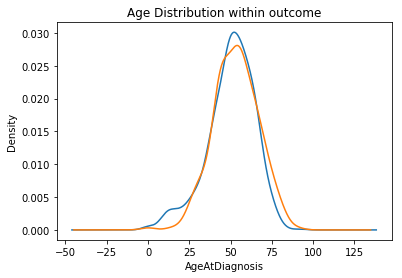

In [32]:
# plots patient age upon diagnosis vs cancer death
LRG.AgeAtDiagnosis[LRG.Cancerdeath == 0].plot(kind='kde')    
LRG.AgeAtDiagnosis[LRG.Cancerdeath == 1].plot(kind='kde')
 # plots an axis lable
plt.xlabel("AgeAtDiagnosis")    
plt.title("Age Distribution within outcome")

## check the correlation among variables

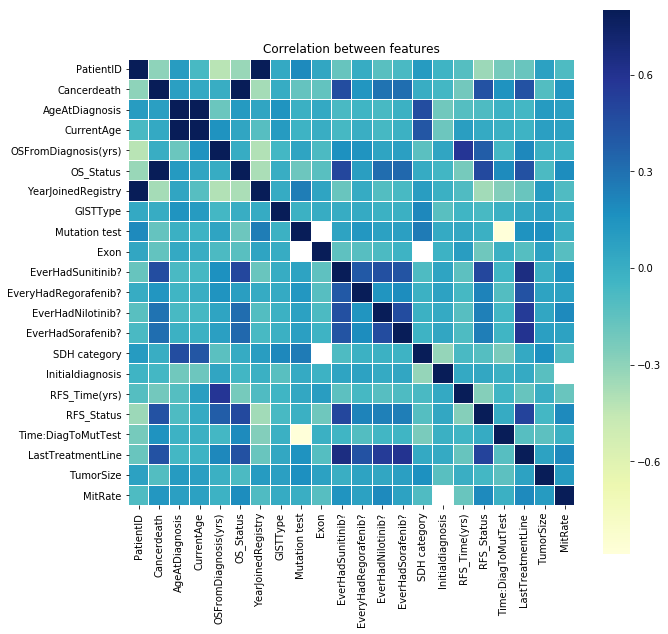

In [35]:
# let us see if some factors are correlated
corr=LRG.corr()#["Survived"]
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=False,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

# Input Features-Convert all catergorical variables into numeric

## catergoarical input

In [15]:
#Convert Categorical variables into Numerical


labelEnc=LabelEncoder()

category=['MaritalStatus',
          'Gender',
          'CountryOfBirth',
          'CountryOfResidence',
          'Race',
          'PresentationCalc',
         'Mutation', 
          'Gene',
          'PrimaryTumorlocation',
          'NIHrisk', 
          'SDH+Wildtype',
          'Progression in 2nd line?',
          'Had Adjuvant?',
          'Progression in 1M?',
          'Stomach?'
         ]
for col in category:
    LRG[col]=labelEnc.fit_transform(LRG[col])


LRG.head(20)

,MaritalStatus,Cancerdeath,AgeAtDiagnosis,CurrentAge,OS_Status,YearJoinedRegistry,Gender,GISTType,Mutation test,Mutation,...,Progression in 1M?,Progression in 2nd line?,RFS_Time(yrs),RFS_Status,Time:DiagToMutTest,Had Adjuvant?,LastTreatmentLine,NIHrisk,TumorSize,MitRate
0,0,1,45.9,48.0,1,2004,1,3,0,15,...,0,0,0.002738,1,3000.00,0,0.0,3,0.0,0.0
1,0,0,31.8,41.0,0,2007,0,3,0,15,...,0,0,0.005476,0,3000.00,1,1.3,0,14.0,0.0
2,0,0,54.3,61.0,0,2010,1,3,0,15,...,0,0,0.010951,0,3000.00,0,0.0,0,5.0,0.0
3,0,0,68.3,71.0,1,2009,0,3,0,15,...,1,0,0.024641,1,3000.00,0,1.7,3,0.0,0.0
4,0,0,54.6,61.0,0,2010,0,3,0,15,...,0,0,0.035592,0,3000.00,0,0.0,3,0.5,0.0
5,0,1,52.4,63.0,1,2002,1,3,1,1,...,1,1,0.041068,1,46.60,0,3.0,0,18.0,0.0
6,0,0,50.8,61.0,0,2006,0,3,0,15,...,0,0,0.049281,0,3000.00,0,0.5,3,5.0,0.0
7,0,0,34.5,40.0,0,2011,0,2,1,1,...,0,0,0.049281,0,2.17,1,1.3,3,5.0,0.0
8,0,1,44.9,47.0,1,2003,0,3,0,15,...,1,1,0.071184,1,3000.00,0,3.0,0,7.0,0.0
9,1,0,28.6,39.0,0,2003,1,3,0,15,...,0,0,0.084873,1,3000.00,0,1.7,3,0.0,0.0


## Many of the input are secondary input based on original data
Most of the newly introduced input contain complex clinical variables that are not shown here. 
1.  Year of Registration is calculated from current year to registration date

2. OS from diagnosis is Over all survival time calculated from 
    * if patients died, it is the date of death to the date of diagnosis
    * if patient is still alive, it is the current date - date of diagnosis

3. RSF : Recurrence free survival
    * if patient has tumor recurrence, it is the date of tumor recurrence- the date of diagnosis
    * if patient do not have tumor recurrence, it is the current date - date of diagnosis

These new inputs were established in our online patient registration, which is not performed in this machine learning. The main reason is that these date requires realtime calculation and complicared

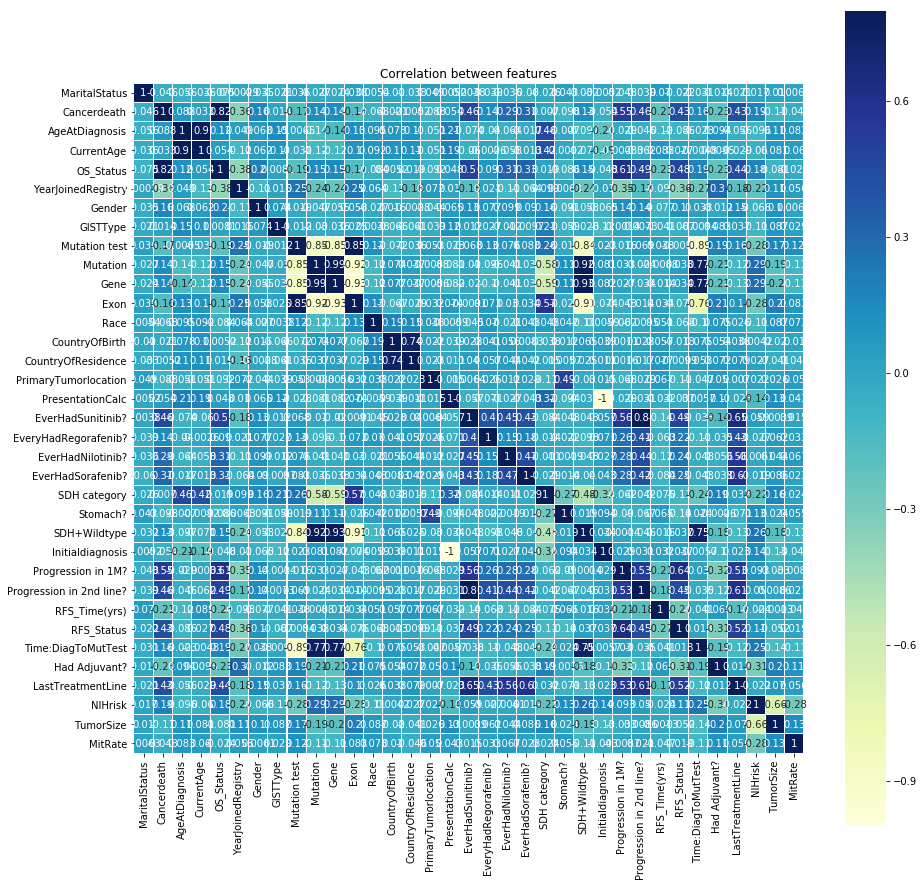

In [15]:
# let us see if some factors are correlated
corr=LRG.corr()#["Survived"]
plt.figure(figsize=(15, 15))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

## Input Feature- that are important to the prediction

### Data prep-data normalization before we find out what input feature is imposrant

In [16]:
#let us do the scaling now for teh numbers that are larger than 10 and make every thing single digit


std_scale = preprocessing.StandardScaler().fit(LRG[['AgeAtDiagnosis', 'CurrentAge', 'Time:DiagToMutTest', 'TumorSize']])
LRG[['AgeAtDiagnosis','CurrentAge', 'Time:DiagToMutTest', 'TumorSize']] = std_scale.transform(LRG[['AgeAtDiagnosis','CurrentAge', 'Time:DiagToMutTest', 'TumorSize']])

In [17]:
#let us see what corelated with survival
LRG.corr()["Cancerdeath"].sort_values(ascending=False)

Cancerdeath                 1.000000
OS_Status                   0.818039
Progression in 1M?          0.546160
EverHadSunitinib?           0.463185
Progression in 2nd line?    0.457272
LastTreatmentLine           0.433822
RFS_Status                  0.432701
EverHadSorafenib?           0.306313
EverHadNilotinib?           0.289379
NIHrisk                     0.185426
Gender                      0.163494
Time:DiagToMutTest          0.158782
Mutation                    0.141220
EveryHadRegorafenib?        0.139229
Gene                        0.136543
SDH+Wildtype                0.133133
AgeAtDiagnosis              0.087550
PresentationCalc            0.054092
CurrentAge                  0.032950
GISTType                    0.013953
SDH category                0.006999
CountryOfResidence         -0.005228
CountryOfBirth             -0.021250
MitRate                    -0.042779
MaritalStatus              -0.046268
Initialdiagnosis           -0.054092
Race                       -0.068250
P

# Using ML pipeline

## pipeline- drop all the variables that are not considered in the ML

In [17]:
# OS_status shows whether patient died or not. It is an outcome. 
#If the person is dead, there no reason why we predict if he/she die from cancer. Who care then!!
# Let us remove it 
LRG = LRG.drop('OS_Status',1 ) 

In [16]:
LRG

,MaritalStatus,Cancerdeath,AgeAtDiagnosis,CurrentAge,YearJoinedRegistry,Gender,GISTType,Mutation test,Mutation,Gene,...,Progression in 1M?,Progression in 2nd line?,RFS_Time(yrs),RFS_Status,Time:DiagToMutTest,Had Adjuvant?,LastTreatmentLine,NIHrisk,TumorSize,MitRate
0,0,1,-0.353500,-0.893791,2004,1,3,0,15,8,...,0,0,0.002738,1,0.793785,0,0.0,3,-0.993138,0.0
1,0,0,-1.342528,-1.415526,2007,0,3,0,15,8,...,0,0,0.005476,0,0.793785,1,1.3,0,1.133534,0.0
2,0,0,0.235707,0.075146,2010,1,3,0,15,8,...,0,0,0.010951,0,0.793785,0,0.0,0,-0.233612,0.0
3,0,0,1.217720,0.820481,2009,0,3,0,15,8,...,1,0,0.024641,1,0.793785,0,1.7,3,-0.993138,0.0
4,0,0,0.256750,0.075146,2010,0,3,0,15,8,...,0,0,0.035592,0,0.793785,0,0.0,3,-0.917185,0.0
5,0,1,0.102434,0.224213,2002,1,3,1,1,1,...,1,1,0.041068,1,-1.261721,0,3.0,0,1.741155,0.0
6,0,0,-0.009796,0.075146,2006,0,3,0,15,8,...,0,0,0.049281,0,0.793785,0,0.5,3,-0.233612,0.0
7,0,0,-1.153140,-1.490060,2011,0,2,1,1,1,...,0,0,0.049281,0,-1.292643,1,1.3,3,-0.233612,0.0
8,0,1,-0.423644,-0.968325,2003,0,3,0,15,8,...,1,1,0.071184,1,0.793785,0,3.0,0,0.070198,0.0
9,1,0,-1.566988,-1.564593,2003,1,3,0,15,8,...,0,0,0.084873,1,0.793785,0,1.7,3,-0.993138,0.0


In [42]:
#let us see what corelated with survival
LRG.corr()["Cancerdeath"].sort_values(ascending=False)

Cancerdeath                 1.000000
Progression in 1M?          0.546160
EverHadSunitinib?           0.463185
Progression in 2nd line?    0.457272
LastTreatmentLine           0.433822
RFS_Status                  0.432701
EverHadSorafenib?           0.306313
EverHadNilotinib?           0.289379
NIHrisk                     0.185426
Gender                      0.163494
Time:DiagToMutTest          0.158782
Mutation                    0.141220
EveryHadRegorafenib?        0.139229
Gene                        0.136543
SDH+Wildtype                0.133133
AgeAtDiagnosis              0.087550
PresentationCalc            0.054092
CurrentAge                  0.032950
GISTType                    0.013953
SDH category                0.006999
CountryOfResidence         -0.005228
CountryOfBirth             -0.021250
MitRate                    -0.042779
MaritalStatus              -0.046268
Initialdiagnosis           -0.054092
Race                       -0.068250
PrimaryTumorlocation       -0.088066
S

## numeric pipeline

In [18]:
num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")), 
        ('std_scaler', StandardScaler()),
    ])

In [19]:
LRG1 = LRG.drop('Cancerdeath',1 ) 

In [20]:
LRG_tr= num_pipeline.fit_transform(LRG1)

In [21]:
LRG_tr

array([[-0.4231903 , -0.35350046, -0.89379095, ...,  1.14536504,
        -0.99313792, -0.31804517],
       [-0.4231903 , -1.34252776, -1.41552596, ..., -0.95456665,
         1.13353419, -0.31804517],
       [-0.4231903 ,  0.23570729,  0.07514551, ..., -0.95456665,
        -0.23361216, -0.31804517],
       ...,
       [ 2.36300313, -0.34648609, -0.67019023, ..., -0.95456665,
         0.22210329, 10.63370405],
       [-0.4231903 ,  0.64955559,  0.07514551, ..., -0.95456665,
        -0.0665165 , 10.85720913],
       [-0.4231903 ,  1.24577772,  1.11861554, ..., -0.95456665,
         2.42472798, 15.77432103]])

## Since we have converted all catergorical variables into numeric, our pipeline will not include the catergorical pipeline

In [22]:

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline)
])

In [23]:
LRG_prepared = full_pipeline.fit_transform(LRG1)
LRG_prepared

array([[-0.4231903 , -0.35350046, -0.89379095, ...,  1.14536504,
        -0.99313792, -0.31804517],
       [-0.4231903 , -1.34252776, -1.41552596, ..., -0.95456665,
         1.13353419, -0.31804517],
       [-0.4231903 ,  0.23570729,  0.07514551, ..., -0.95456665,
        -0.23361216, -0.31804517],
       ...,
       [ 2.36300313, -0.34648609, -0.67019023, ..., -0.95456665,
         0.22210329, 10.63370405],
       [-0.4231903 ,  0.64955559,  0.07514551, ..., -0.95456665,
        -0.0665165 , 10.85720913],
       [-0.4231903 ,  1.24577772,  1.11861554, ..., -0.95456665,
         2.42472798, 15.77432103]])

In [24]:
LRG_tr.shape

(1218, 33)

Both LRG_tr and LRG_prepared are the same

# End-to-end machine learning pipeline
Let's do ML modeling

### Input feature list

In [25]:
# The columns we'll use 

predictors = ['MaritalStatus',
              'Progression in 1M?',
              'EverHadSunitinib?',
              'Progression in 2nd line?',
              'LastTreatmentLine',
              'RFS_Status',               
                'EverHadSorafenib?',          
                'EverHadNilotinib?',          
                'NIHrisk',                   
                'Gender',                   
                'Time:DiagToMutTest',         
                'Mutation',                    
                'EveryHadRegorafenib?',        
                'Gene',                       
                'SDH+Wildtype',                
                'AgeAtDiagnosis',           
                'PresentationCalc',          
                'CurrentAge',                 
                'GISTType',                   
                'SDH category',                
                'CountryOfResidence',         
                'CountryOfBirth',             
                'MitRate',                    
                'MaritalStatus',             
                'Initialdiagnosis',           
                'Race',
                'PrimaryTumorlocation',
                'Stomach?',     
                'TumorSize',
                'Exon',
                'Mutation test',
                'RFS_Time(yrs)',
                'Had Adjuvant?',
                'YearJoinedRegistry'
             ]
target="Cancerdeath"


## Train a linear regression model
This is the best base line model

### Metrics- crossvalidation and accuracy report

In [47]:
lin_reg = LinearRegression()
lin_reg.fit(LRG_tr, LRG["Cancerdeath"])
kf = KFold(LRG_tr.shape[0], n_folds=10, random_state=42)

In [27]:
%%time
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

scores_line = cross_val_score(lin_reg, LRG_tr, LRG["Cancerdeath"], cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(scores_line)

[0.51637345 0.41186179 0.41239856 0.53835235 0.43069104 0.52998741
 0.45117495 0.50598908 0.46364668 0.42573624]
Wall time: 26.1 ms


### Classification report metrics for linear model


In [28]:
# THis is a wrong analysis
predictions_l = []
for train, test in kf:
    train_predictors = (LRG[predictors].iloc[train,:])
    # The guess
    train_target = LRG["Cancerdeath"].iloc[train]
    # fit
    lin_reg.fit(train_predictors, train_target)
    
    test_predictions = lin_reg.predict(LRG[predictors].iloc[test,:])
    predictions_l.append(test_predictions)

predictions_line = np.concatenate(predictions_l, axis=0)
predictions_linear = np.concatenate(predictions_l, axis=0)
# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions_line[predictions_line > .5] = 1
predictions_line[predictions_line <=.5] = 0
accuracy_linear=sum(LRG["Cancerdeath"]==predictions_line)/len(LRG["Cancerdeath"])
print(accuracy_linear)

0.8752052545155994


In [29]:
predictions_linear

array([ 0.5707352 , -0.09892345,  0.03527548, ...,  0.62999502,
       -0.13584385, -0.0159539 ])

In [30]:
predictions_line

array([1., 0., 0., ..., 1., 0., 0.])

In [31]:
from sklearn.metrics import classification_report
report = classification_report(LRG["Cancerdeath"], predictions_line)
print(report)

             precision    recall  f1-score   support

          0       0.91      0.93      0.92       924
          1       0.76      0.70      0.73       294

avg / total       0.87      0.88      0.87      1218



* That sounds like overfit

### F1 score evaluation

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_macro = f1_score(LRG["Cancerdeath"], predictions_line, average='macro')

In [34]:
f1_w=f1_score(LRG["Cancerdeath"], predictions_line, average='weighted')

### report table

In [35]:
results = pd.DataFrame(columns=["Method", "Accuracy", "f1-macro",'f1-weighted', 'training time (ms)', 'p-ttest_Accuracy vs Linear regression', 'p-ttest_Accuracy vs Grid Search' ])

In [36]:
results.loc[len(results)] = ["LinearRegression", 
                             round(scores_line.mean(), 3), 
                             round(f1_macro, 3),
                             round(f1_w, 3),
                             26,
                             "N/A",
                            7.451058641592047e-13
                                                         
                             ]
results

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.469,0.825,0.873,26,N/A,7.451059e-13


## Let's do a grid search

In [37]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(LRG_tr, LRG["Cancerdeath"])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [39]:
# we can get the best feature from
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [40]:
%%time

Cs = np.logspace(-6, -1, 10)
svc = svm.SVC()
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),n_jobs=-1)
clf.fit(LRG_tr, LRG["Cancerdeath"])
scores_GS = cross_val_score(clf, LRG_tr, LRG["Cancerdeath"], cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(scores_GS)

[0.81967213 0.86065574 0.87704918 0.8647541  0.8442623  0.88934426
 0.8442623  0.81967213 0.75       0.82377049]
Wall time: 27.6 s


In [41]:
scores_GS = cross_val_score(clf, LRG_tr, LRG["Cancerdeath"], cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(scores_GS)

[0.81967213 0.86065574 0.87704918 0.8647541  0.8442623  0.88934426
 0.8442623  0.81967213 0.75       0.82377049]


### Classification report metrics for GS

In [ ]:
predictions_gs = []
for train, test in kf:
    train_predictors = (LRG[predictors].iloc[train,:])
    # The guess
    train_target = LRG["Cancerdeath"].iloc[train]
    # fit
    clf.fit(train_predictors, train_target)
    
    test_predictions = clf.predict(LRG[predictors].iloc[test,:])
    predictions_gs.append(test_predictions)

predictions_grid = np.concatenate(predictions_gs, axis=0)
predictions_GS = np.concatenate(predictions_gs, axis=0)
# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions_grid[predictions_grid > .5] = 1
predictions_grid[predictions_grid <=.5] = 0
accuracy_gs=sum(LRG["Cancerdeath"]==predictions_grid)/len(LRG["Cancerdeath"])
print(accuracy_gs)

In [118]:

report = classification_report(LRG["Cancerdeath"], predictions_grid)
print(report)

             precision    recall  f1-score   support

          0       0.77      1.00      0.87       924
          1       0.87      0.04      0.08       294

avg / total       0.79      0.77      0.68      1218



In [119]:
predictions_grid

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### f1 metrics evaluation for grid search

In [120]:
f1_macro = f1_score(LRG["Cancerdeath"], predictions_grid, average='macro')
f1_w=f1_score(LRG["Cancerdeath"], predictions_grid, average='weighted')

In [121]:
f1_macro

0.47554557446789086

### significant test using t-test

In [122]:
t,p_gs=ttest_ind(scores_line, scores_GS, equal_var=False)
p_gs

9.810450018074848e-13

### report for grid search

In [123]:
results.loc[len(results)] = ["Grid search", 
                             round(scores_GS.mean(), 3), 
                             round(f1_macro, 3),
                             round(f1_w, 3),
                             26700,
                             p_gs,
                             "N/A",
                                                         
                             ]
results

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.469,0.825,0.873,22,N/A,7.45106e-13
1,Grid search,0.839,0.476,0.678,26700,9.81045e-13,N/A


* Not bad for a initial test, after I cleaned the data

## Random Forest model

### Randon search with metrics-accuracy and f1 score

In [65]:
n_estimators=randint(1,200)
max_depth= randint(1,10)
min_samples_split= randint(1,3)
min_samples_leaf= randint(1,3)

rf = RandomForestClassifier(random_state=42,
                            n_estimators=n_estimators, 
                            max_depth=max_depth,
                            min_samples_split=min_samples_split, 
                            min_samples_leaf=min_samples_leaf)

In [66]:

%%time
rf.fit(LRG_tr,LRG["Cancerdeath"])
kf = KFold(LRG_tr.shape[0], n_folds=10)
predictions_rd = cross_validation.cross_val_predict(rf, LRG_tr,LRG["Cancerdeath"],cv=kf)

scores_rd = cross_val_score(rf, LRG_tr, LRG["Cancerdeath"], cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_rd))

0.8613263785394933
Wall time: 3.66 s


In [67]:
f1_macro = f1_score(LRG["Cancerdeath"], predictions_rd, average='macro')
f1_w=f1_score(LRG["Cancerdeath"], predictions_rd, average='weighted')

### ttest for randon search

In [68]:
t,p_rd_line=ttest_ind(scores_line, scores_rd, equal_var=False)
t,p_rd_gs=ttest_ind(scores_GS, scores_rd, equal_var=False)

In [69]:
p_rd_gs

0.3933921327359743

In [70]:
results.loc[len(results)] = ["RandomSearch", 
                             round(scores_rd.mean(), 3), 
                             round(f1_macro, 3),
                             round(f1_w, 3),
                             7240,
                             p_rd_line,
                             p_rd_gs
                            ]
results   

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.469,0.825,0.873,44,N/A,7.45106e-13
1,Grid search,0.839,0.476,0.678,40.4,9.81045e-13,N/A
2,RandomSearch,0.861,0.803,0.859,7240,7.10725e-11,0.393392


It's a good start for random search

## Input variable importance
### see features from grid search

In [71]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.00967682, 0.06469583, 0.05473076, 0.07992001, 0.01398617,
       0.00298014, 0.01121616, 0.00987664, 0.0070129 , 0.00869302,
       0.03733208, 0.02710367, 0.02153037, 0.0344518 , 0.00380831,
       0.04089805, 0.01429246, 0.0128867 , 0.03094242, 0.01758883,
       0.01204098, 0.00916152, 0.00354598, 0.11685122, 0.05775204,
       0.05867804, 0.04682352, 0.02264156, 0.01580064, 0.07030128,
       0.01486767, 0.04561521, 0.02229718])

In [72]:
attributes = list(LRG)
sortedFeatures = sorted(zip(feature_importances, attributes), reverse=False)

In [73]:
np.array(sortedFeatures)[:, 0]

array(['0.0029801382529891425', '0.0035459832147822345',
       '0.0038083089179593087', '0.00701290303079109',
       '0.00869301947216741', '0.009161520696036258',
       '0.009676824900754352', '0.009876641152925353',
       '0.011216161763271153', '0.012040977824679767',
       '0.01288670481869172', '0.013986174519111992',
       '0.014292463410471905', '0.014867671116193259',
       '0.015800637548192647', '0.01758882611266815',
       '0.021530368129445053', '0.022297183597446132',
       '0.022641556528597544', '0.027103671425480282',
       '0.030942418751505215', '0.034451804805663316',
       '0.037332078964866205', '0.040898048119242456',
       '0.04561520837404176', '0.04682352102180638',
       '0.05473076167992273', '0.057752044613809846',
       '0.05867803988671087', '0.06469582643747875',
       '0.07030127580238098', '0.07992001496933351', '0.1168512201405832'],
      dtype='<U32')

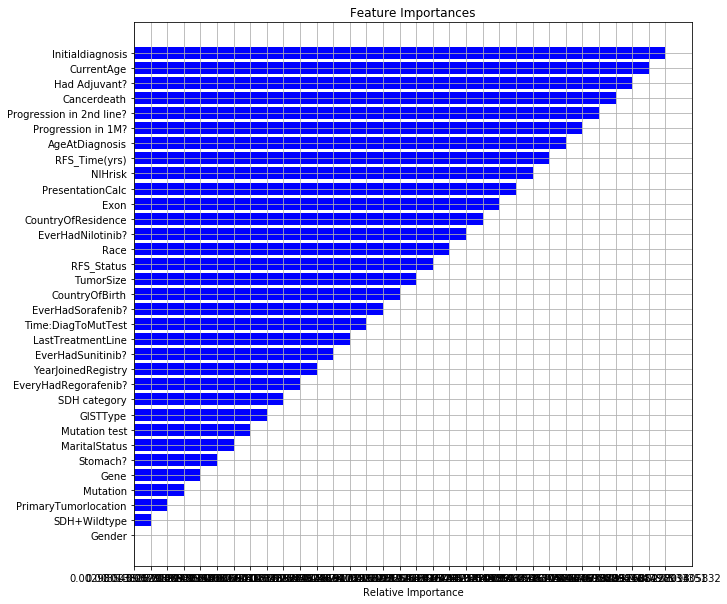

In [74]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

### Boosting feature to see what is important-using random search

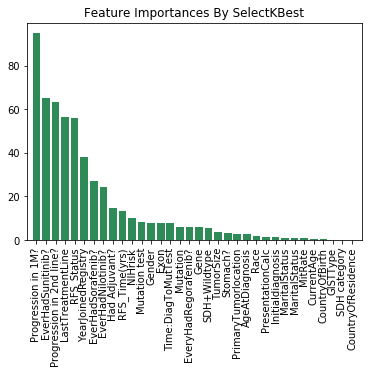

In [75]:
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(LRG[predictors], LRG["Cancerdeath"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

plt.figure()
plt.title("Feature Importances By SelectKBest")
plt.bar(range(np.size(predictors)), scores[indices],
       color="seagreen", align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

## Logistic regression modeling this is done before tuning

### try a few different parameters

In [76]:
%%time
lr = LogisticRegression(penalty='l2',solver='lbfgs', max_iter = 500, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state = 42)
scores_lr = cross_val_score(lr, LRG_tr, LRG["Cancerdeath"], scoring = 'accuracy', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_lr))

0.9016393442622949
Wall time: 117 ms


In [42]:
lr = LogisticRegression(penalty='l2',solver='lbfgs', max_iter = 1000, random_state=1)
cv = ShuffleSplit(n_splits=5, test_size=0.05, random_state = 42)
scores_lr = cross_val_score(lr, LRG_tr, LRG["Cancerdeath"])
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_lr))

0.8275862068965517


In [43]:
lr = LogisticRegression( max_iter = 500, solver='saga', random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state = 42)
scores_lr = cross_val_score(lr, LRG_tr, LRG["Cancerdeath"], scoring = 'accuracy', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_lr))

0.9016393442622949


In [44]:
lr = LogisticRegression(max_iter = 500, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state = 42)
scores_lr = cross_val_score(lr, LRG_tr, LRG["Cancerdeath"], scoring = 'f1', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_lr))

0.7732530962886901


In [45]:
lr = LogisticRegression(max_iter = 500, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state = 42)
scores_lr = cross_val_score(lr, LRG_tr, LRG["Cancerdeath"], scoring = 'precision', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_lr))

0.8200607176431765


OK, now we know the L2 works fine. 

### f1 score and ttest

In [48]:
%%time
predictions_lr = []
lr = LogisticRegression(penalty='l2',solver='lbfgs', max_iter = 500, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state = 42)
for train, test in kf:
    train_predictors = (LRG[predictors].iloc[train,:])
    # The guess
    train_target = LRG["Cancerdeath"].iloc[train]
    # fit
    lr.fit(train_predictors, train_target)
    
    test_predictions = lr.predict(LRG[predictors].iloc[test,:])
    predictions_lr.append(test_predictions)

predictions_logr = np.concatenate(predictions_lr, axis=0)
predictions_LogisticR = np.concatenate(predictions_lr, axis=0)
# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions_logr[predictions_logr > .5] = 1
predictions_logr[predictions_logr <=.5] = 0
score_lr=sum(LRG["Cancerdeath"]==predictions_logr)/len(LRG["Cancerdeath"])
print(score_lr)

0.8415435139573071
Wall time: 971 ms


In [82]:
f1_macro = f1_score(LRG["Cancerdeath"], predictions_logr, average='macro')
f1_w=f1_score(LRG["Cancerdeath"], predictions_logr, average='weighted')

In [83]:
t,p_lr_line=ttest_ind(scores_line, scores_lr, equal_var=False)
t,p_lr_gs=ttest_ind(scores_GS, scores_lr, equal_var=False)

### report table

In [84]:
results.loc[len(results)] = ["LogisticRegression", 
                             round(scores_lr.mean(), 3), 
                             round(f1_macro, 3),
                             round(f1_w, 3),
                             1010,
                             p_lr_line,
                             p_lr_gs
                            ]
results 

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.469,0.825,0.873,44,N/A,7.45106e-13
1,Grid search,0.839,0.476,0.678,40.4,9.81045e-13,N/A
2,RandomSearch,0.861,0.803,0.859,7240,7.10725e-11,0.393392
3,LogisticRegression,0.820,0.778,0.839,1010,1.20316e-07,0.573887


## SVM Classifier SVM


### try linear SVM first

In [85]:
%%time

lin_clf = LinearSVC(random_state=42)

#Fit Model
scores_LinearSVC= cross_val_score(lin_clf, LRG_tr, LRG["Cancerdeath"], cv=cv, scoring="accuracy")
np.mean(scores_LinearSVC)

Wall time: 858 ms


In [86]:
lin_clf.fit(LRG_tr, LRG["Cancerdeath"])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [87]:
prediction_lin_clf = lin_clf.predict(LRG_tr)
score_lin_clf=sum(LRG["Cancerdeath"]==prediction_lin_clf)/len(LRG["Cancerdeath"])
score_lin_clf


0.8924466338259441

In [88]:
f1_macro = f1_score(LRG["Cancerdeath"], prediction_lin_clf, average='macro')
f1_w=f1_score(LRG["Cancerdeath"], prediction_lin_clf, average='weighted')

In [89]:
t,p_lin_clf_line=ttest_ind(scores_line, scores_LinearSVC, equal_var=False)
t,p_lin_clf_gs=ttest_ind(scores_GS, scores_LinearSVC, equal_var=False)

In [90]:
results.loc[len(results)] = ["Linear_SVM", 
                             round(scores_LinearSVC.mean(), 3), 
                             round(f1_macro, 3),
                             round(f1_w, 3),
                             858,
                             p_lin_clf_line,
                             p_lin_clf_gs
                            ]
results 

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.469,0.825,0.873,44,N/A,7.45106e-13
1,Grid search,0.839,0.476,0.678,40.4,9.81045e-13,N/A
2,RandomSearch,0.861,0.803,0.859,7240,7.10725e-11,0.393392
3,LogisticRegression,0.820,0.778,0.839,1010,1.20316e-07,0.573887
4,Linear_SVM,0.897,0.849,0.891,858,1.30674e-13,0.00894631


### Use non-linear kernels

In [91]:
%%time

svm_clf = SVC(decision_function_shape="ovr")

#Fit Model
scores_svm_clf= cross_val_score(svm_clf, LRG_tr, LRG["Cancerdeath"], cv=cv, scoring="accuracy")
np.mean(scores_svm_clf)

Wall time: 317 ms


In [92]:
svm_clf.fit(LRG_tr, LRG["Cancerdeath"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
prediction_svm_clf = svm_clf.predict(LRG_tr)
score_svm_clf=sum(LRG["Cancerdeath"]==prediction_svm_clf)/len(LRG["Cancerdeath"])
score_svm_clf

0.9178981937602627

In [94]:
f1_macro = f1_score(LRG["Cancerdeath"], prediction_svm_clf, average='macro')
f1_w=f1_score(LRG["Cancerdeath"], prediction_svm_clf, average='weighted')

t,p_svm_clf_line=ttest_ind(scores_line, scores_svm_clf, equal_var=False)
t,p_svm_clf_gs=ttest_ind(scores_GS, scores_svm_clf, equal_var=False)

In [95]:
results.loc[len(results)] = ["non-Linear_SVM", 
                             round(scores_svm_clf.mean(), 3), 
                             round(f1_macro, 3),
                             round(f1_w, 3),
                             317,
                             p_svm_clf_line,
                             p_svm_clf_gs
                            ]
results 

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.469,0.825,0.873,44,N/A,7.45106e-13
1,Grid search,0.839,0.476,0.678,40.4,9.81045e-13,N/A
2,RandomSearch,0.861,0.803,0.859,7240,7.10725e-11,0.393392
3,LogisticRegression,0.820,0.778,0.839,1010,1.20316e-07,0.573887
4,Linear_SVM,0.897,0.849,0.891,858,1.30674e-13,0.00894631
5,non-Linear_SVM,0.884,0.885,0.917,317,6.57305e-13,0.0121774


### Tune hyperparameters

In [96]:

svm_clf = SVC(decision_function_shape="ovr")
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(.1, 1)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2,n_jobs=-1)
rnd_search_cv.fit(LRG_tr, LRG["Cancerdeath"])  #### use a subset of the data to speed things up

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002377AC59BE0>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000237004D19B0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [97]:
rnd_search_cv.best_estimator_

SVC(C=0.9392291690393929, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.022692334282739382,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [98]:
rnd_search_cv.best_score_

0.8399014778325123

it does not seems to improve the accuracy!

# Extra method
There is a much easier way to do all the ML using a bew package called : TPOT

Description
Consider TPOT your Data Science Assistant. TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for your data.

Once TPOT is finished searching (or you get tired of waiting), it provides you with the Python code for the best pipeline it found so you can tinker with the pipeline from there.

TPOT is built on top of scikit-learn, so all of the code it generates should look familiar... if you're familiar with scikit-learn, anyway.

TPOT is still under active development and we encourage you to check back on this repository regularly for updates.

## Run a pipeline for pipeline
So we can use 6 lines of code to do all the work described above in chapter 7

In [26]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

C:\Users\ywang\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(LRG_tr, LRG["Cancerdeath"],
                                                    train_size=0.75, test_size=0.25)


In [28]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_mnist_pipeline.py')

C:\Users\ywang\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Generation 1 - Current best internal CV score: 0.866346969732572


Generation 2 - Current best internal CV score: 0.8718414099561642


Generation 3 - Current best internal CV score: 0.8718414099561642


Generation 4 - Current best internal CV score: 0.8740213279236801


Generation 5 - Current best internal CV score: 0.8762609035060922



Best pipeline: KNeighborsClassifier(Normalizer(LogisticRegression(input_matrix, C=1.0, dual=False, penalty=l2), norm=max), n_neighbors=26, p=2, weights=distance)
0.8524590163934426


True

## Now we try a dummy method

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# NOTE: Make sure that the class is labeled 'target' in the data file

X_train, X_test, y_train, y_test = train_test_split(LRG_tr, LRG["Cancerdeath"],
                                                    train_size=0.80, test_size=0.20)


exported_pipeline = KNeighborsClassifier(n_neighbors=26, weights="distance")

exported_pipeline.fit(X_train, y_train)
outcome = exported_pipeline.predict(X_test)

In [60]:
accuracy_dummy=sum(y_test==outcome)/len(y_test)
accuracy_dummy

0.8483606557377049

## Now we used neural network


In [83]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(12, input_dim=33, activation='relu'))
model.add(Dense(33, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [85]:

model.fit(X_train, y_train, epochs=150, batch_size=10)
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
974/974 [==============================] - ETA: 33s - loss: 0.8289 - acc: 0.30 - ETA: 0s - loss: 0.6790 - acc: 0.5774 - 0s 457us/step - loss: 0.6146 - acc: 0.6622
Epoch 2/150
974/974 [==============================] - ETA: 0s - loss: 0.5308 - acc: 0.900 - ETA: 0s - loss: 0.4429 - acc: 0.819 - 0s 105us/step - loss: 0.4208 - acc: 0.8285
Epoch 3/150
974/974 [==============================] - ETA: 0s - loss: 0.5619 - acc: 0.800 - ETA: 0s - loss: 0.3437 - acc: 0.850 - 0s 97us/step - loss: 0.3463 - acc: 0.8511
Epoch 4/150
974/974 [==============================] - ETA: 0s - loss: 0.4545 - acc: 0.800 - ETA: 0s - loss: 0.3014 - acc: 0.872 - 0s 94us/step - loss: 0.3162 - acc: 0.8604
Epoch 5/150
974/974 [==============================] - ETA: 0s - loss: 0.1878 - acc: 0.900 - ETA: 0s - loss: 0.2907 - acc: 0.878 - 0s 103us/step - loss: 0.2993 - acc: 0.8686
Epoch 6/150
974/974 [==============================] - ETA: 0s - loss: 0.1079 - acc: 1.000 - ETA: 0s - loss: 0.2870 - acc: 0.877 - 

974/974 [==============================] - ETA: 0s - loss: 0.0026 - acc: 1.000 - ETA: 0s - loss: 0.0441 - acc: 0.990 - 0s 91us/step - loss: 0.0467 - acc: 0.9887
Epoch 96/150
974/974 [==============================] - ETA: 0s - loss: 0.0308 - acc: 1.000 - ETA: 0s - loss: 0.0358 - acc: 0.992 - 0s 95us/step - loss: 0.0455 - acc: 0.9897
Epoch 97/150
974/974 [==============================] - ETA: 0s - loss: 0.1182 - acc: 0.900 - ETA: 0s - loss: 0.0510 - acc: 0.987 - 0s 94us/step - loss: 0.0455 - acc: 0.9908
Epoch 98/150
974/974 [==============================] - ETA: 0s - loss: 0.0160 - acc: 1.000 - ETA: 0s - loss: 0.0465 - acc: 0.989 - 0s 94us/step - loss: 0.0438 - acc: 0.9908
Epoch 99/150
974/974 [==============================] - ETA: 0s - loss: 0.0223 - acc: 1.000 - ETA: 0s - loss: 0.0363 - acc: 0.996 - 0s 91us/step - loss: 0.0432 - acc: 0.9918
Epoch 100/150
974/974 [==============================] - ETA: 0s - loss: 0.0324 - acc: 1.000 - ETA: 0s - loss: 0.0387 - acc: 0.990 - 0s 96us/st

In [82]:
from sklearn.neural_network import MLPClassifier
kf = KFold(LRG_tr.shape[0], n_folds=10, random_state=42)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
scores_nw = cross_val_score(clf, LRG_tr, LRG["Cancerdeath"], scoring = 'accuracy', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(np.mean(scores_nw))

0.8778688524590164


it is not as good as logistic regression

# Final report


## Clear view of the ML result

In [282]:
results

,Method,Accuracy,f1-macro,f1-weighted,training time (ms),p-ttest_Accuracy vs Linear regression,p-ttest_Accuracy vs Grid Search
0,LinearRegression,0.468,0.825,0.873,44,N/A,7.45106e-13
1,Grid search,0.839,0.476,0.678,40.4,7.45106e-13,N/A
2,RandomSearch,0.869,0.814,0.866,7240,1.3562e-12,0.185874
3,LogisticRegression,0.902,0.779,0.839,2180,8.30754e-14,0.00165789
4,Linear_SVM,0.897,0.846,0.888,1680,6.11241e-14,0.00382738
5,non-Linear_SVM,0.884,0.885,0.917,594,4.70556e-13,0.0121774


## Summary of the result

* In this project, we used the LRG data base to predict whether patient will die from the cancer. This is a classification task using multiple predictive parameters. Many patients do not have complete record, resulting artificial missing data filling or removal of cases. In the end, we have 33 numeric predictors.
* After data cleaning and standarlization, I applied several machine learning methods and hyperparameter tuning that were taughted in the class. 
* By comparing these accuracy from different methods, logistic regression came on top and has an over 90% of correction. SVM has a very closed accuracy. Interestingly, SVM has a weighted f1-score, which is much better than that from LR method. This might have somthing to do with the balance of 0 and 1 count in these two method. 
* After spending hours in phase II and III, I heard there is a package call tpot that can do all the thing "machinely" and tell us which method is the best. Although it came too late, I was able to use as a validation, which shows LR is the best method. 

## What did I learn from this class, beyond this project


* I wish we can talk more about NN in the class. At the end of the project, I tested the NN method which gave a ~86% accuracy without tuning. it is not bad. 
* I metioned earlier that we will have 446 new patients rolling in from Chile and Mexico. Due to legal issue, I cannot use the data here. However, I took a peak and shown below in chapter 10 (Confidential!!!!!)
* Now we have over 90% accuracy, we can reasonabelly ignore the high typeI error. We will update our website. When patients login in next month, they will see a warning saying "high risk, asking your doctor to consider increase your chemotherapy dose"

# We have 446 cases arrival that can be used as testing cohort

In [89]:
LRG_test = pd.read_csv("test_cohort.csv")
LRG_test.head()

,No.,ID,DOB,Age,Estado civil,Gender,Date of first tumor,Diagnostico GIST,TIME SUB_DX,Initial diagnostic,...,SITO METS - 2,Date Progression,Unnamed: 68,RFS,PLE_Meses,PLE_Años,Death,Lastcontact,OS_month,SVG_Años
0,1,FGM0001,29435,31,1,0,34104,40909,223,0,...,0,40928,303,227.47,224,18.7,0,42876,288,24
1,2,FGM0002,27121,37,1,1,40664,40807,4,1,...,0,41456,85,26.40,7,0.6,1,42941,74,6
2,3,FGM0003,27675,30,1,1,33970,38718,156,0,...,0,38718,308,158.27,156,13,0,42017,264,22
3,4,FGM0004,21183,53,1,0,40743,40747,0,0,...,0,42948,82,73.50,73,6.1,1,42948,72,6
4,5,FGM0005,19166,59,1,0,41034,41037,0,1,...,0,42964,72,64.33,0,0,1,42964,63,5


In [90]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
LRG_test.describe()

,No.,Estado civil,Gender,Date of first tumor,Diagnostico GIST,TIME SUB_DX,Initial diagnostic,Otro,Tumor primario,Sintomas 1,Sintomas 2,Sintomas 3,Biopsia,Surgery,No. Surgeries,Fecha cirguía,Clean margins,Tumor rupture,Tumor size,tumor type,IHC,Marcadores 1,Marcadores 2,mitotic index,EC,EC-DX,treatment 1,treatment 2,metastasectomy,Unnamed: 34,Primera línea.1,1 Línea inicio,1 Línea fin,Duración 1a línea,Initial dose,Final,End dose treatment,Dose change reason,side effects-1,side effectss-2,side effects-3,Unnamed: 49,second line,Segunda línea inicio,Segunda línea fin,Duración 2a línea,Unnamed: 54,Tercera línea,Tercera línea inicio,Duración 3a línea,Unnamed: 60,Recurrence,Local o Mets,Núm. Mets,SITO METS,SITO METS - 2,Unnamed: 68,RFS,Death,OS_month,SVG_Años
count,446.000000,446.00000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,445.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.0,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,0.0,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,0.0,446.000000,24.000000,22.000000,444.000000,0.0,446.000000,6.000000,445.000000,0.0,446.000000,446.000000,103.000000,446.000000,446.000000,446.000000,444.000000,446.000000,446.000000,446.000000
mean,223.589686,1.58296,0.535874,41222.125561,41359.226457,6.497758,0.892377,0.372197,1.695067,1.522422,0.347534,0.071910,0.367713,0.858744,0.964126,35316.934978,0.874439,1.690583,1.695067,1.255605,1.0,1.656951,1.719731,0.497758,1.479821,1.264574,2.412556,0.760090,0.713004,NaN,1.926009,28329.775785,29200.843049,25.136771,0.721973,0.948430,0.838565,0.195067,1.237668,1.188341,0.547085,NaN,96.367713,41472.916667,42234.772727,0.869369,NaN,0.029148,42148.666667,0.022472,NaN,0.656951,0.625561,1.087379,0.845291,0.078475,66.035874,36.125518,0.843049,48.089686,3.573991
std,129.035174,1.24018,0.499271,1549.374052,1407.827593,22.273857,0.310252,1.218043,1.017299,1.251764,1.204050,0.802163,0.482724,0.348676,0.583338,14543.842582,0.387932,0.711543,0.747324,0.633983,0.0,0.520401,1.236129,0.500556,0.865465,0.441601,1.951139,1.694227,0.893503,NaN,1.395465,19313.628442,19885.535805,34.573636,0.649156,1.055551,0.821586,0.673794,1.130583,1.861605,1.817834,NaN,2033.738277,1391.669686,782.074283,5.739732,NaN,0.262319,414.701660,0.334823,NaN,0.475261,0.897523,0.373295,1.537783,0.581075,51.628044,35.743629,0.364163,44.808467,3.723916
min,1.000000,1.00000,0.000000,33239.000000,36728.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,36008.000000,40238.000000,0.000000,NaN,0.000000,41852.000000,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,112.250000,1.00000,0.000000,40763.750000,40916.750000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,39424.750000,1.000000,2.000000,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,0.000000,41257.500000,41760.500000,0.000000,NaN,0.000000,41859.750000,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,30.250000,12.192500,1.000000,18.000000,1.000000
50%,223.500000,1.00000,1.000000,41678.000000,41789.500000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,41401.000000,1.000000,2.000000,2.000000,1.000000,1.0,2.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,NaN,1.000000,41030.000000,42869.000000,11.500000,1.000000,1.000000,1.000000,0.000000,1.00000

In [91]:
LRG_test.isnull().sum()

No.                         0
ID                          0
DOB                         0
Age                         0
Estado civil                0
Gender                      0
Date of first tumor         0
Diagnostico GIST            0
TIME SUB_DX                 0
Initial diagnostic          0
Otro                        0
Tumor primario              0
Sintomas 1                  0
Sintomas 2                  0
Sintomas 3                  1
Biopsia                     0
Surgery                     0
\nNo. Surgeries             0
Fecha cirguía               0
Clean margins               0
\nTumor rupture             0
Tumor size                  0
tumor type                  0
IHC                         0
Marcadores 1                0
Marcadores 2                0
\nmitotic index             0
EC                          0
EC-DX                       0
treatment 1                 0
treatment 2                 0
metastasectomy              0
Fecha metastasectomía     404
Fecha meta

You can see that oncologist in different countries make patient registry differently  
1. There are many variables that are not translated yet. There will be a huge effort in the next few weeks for our colleagues to do the qulity control and translation.
2. We have to trasnfer the test cohort format and make it fitting in our training columns.
3. There are so many missing data, which is a problem.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2B5DA6390>,
      dtype=object)

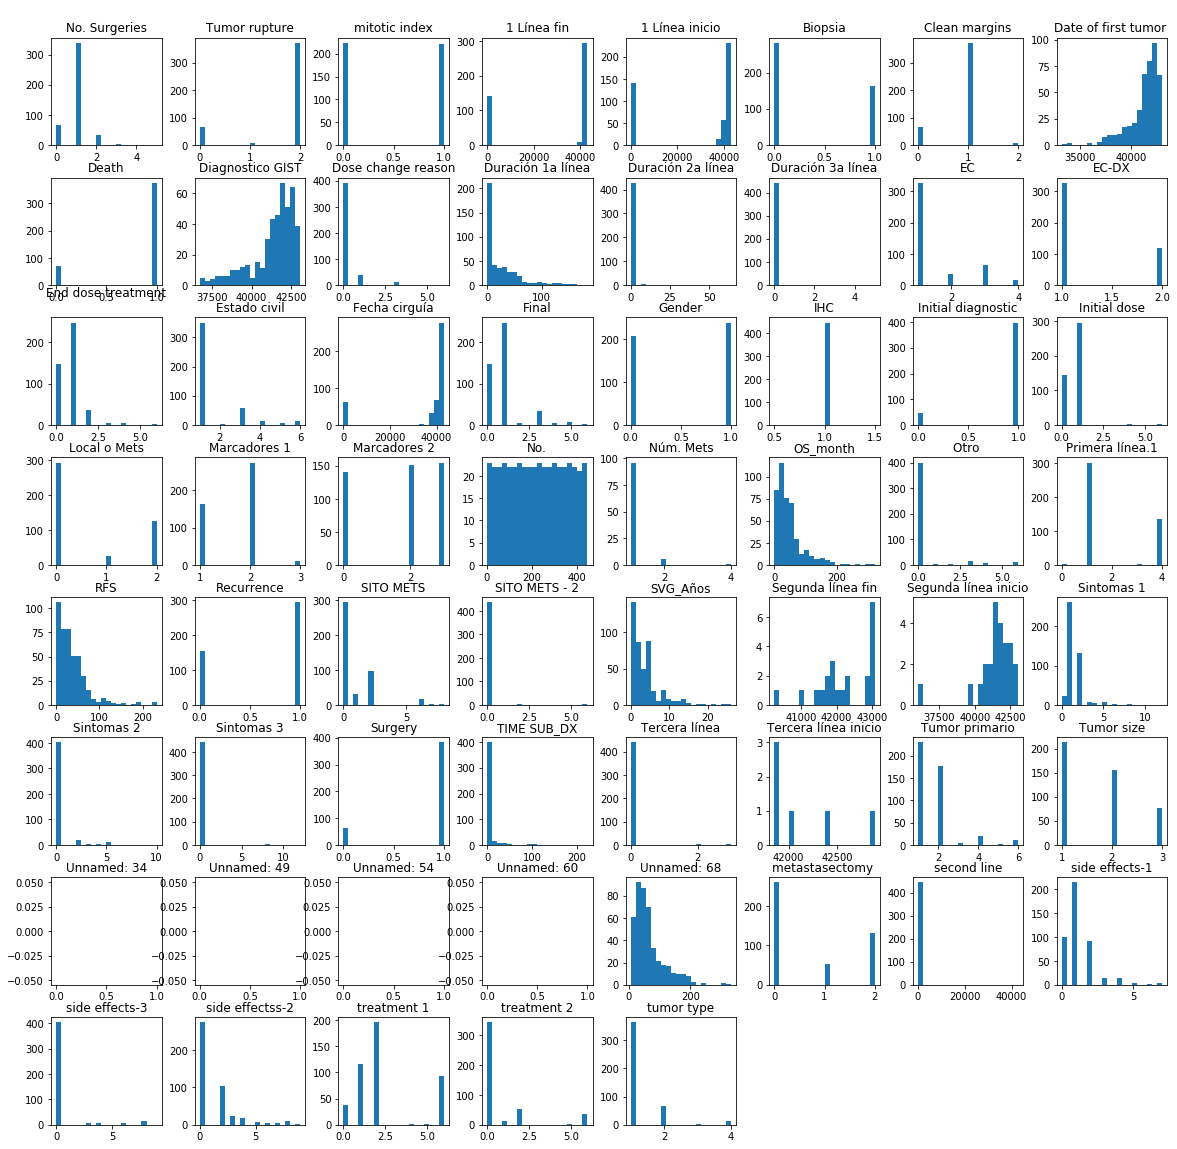

In [92]:
%matplotlib inline
LRG_test.hist(bins=20,figsize=(20,20),grid=False)

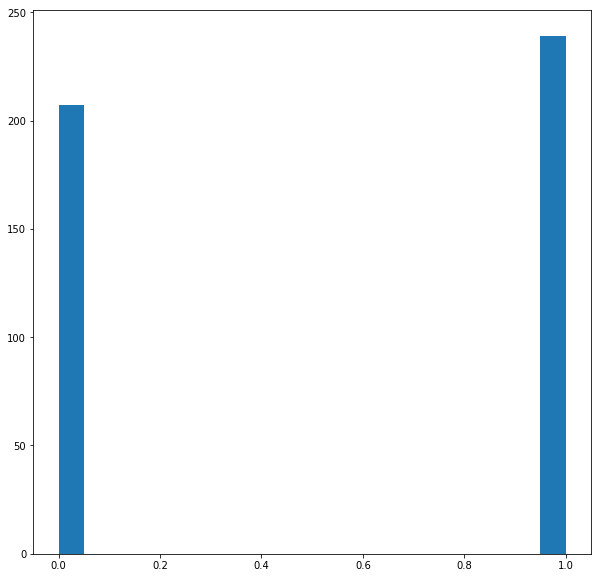

In [93]:
%matplotlib inline
LRG_test['Gender'].hist(bins=20,figsize=(10,10),grid=False)

Text(0.5,1,'Survival Breakdown (0 = Died, 1 = Alive)')

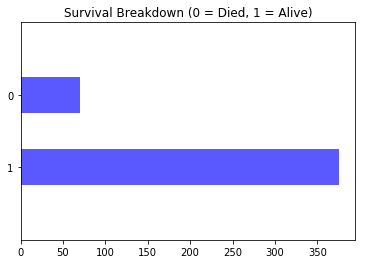

In [97]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
LRG_test.Death.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(LRG_test.Death.value_counts())) 
plt.title("Survival Breakdown (0 = Died, 1 = Alive)")

The test cohort has way too less death cases ratio comparing to traiing cohort shown below!!!!!

Text(0.5,1,'Survival Breakdown (1 = Died, 0 = Alive)')

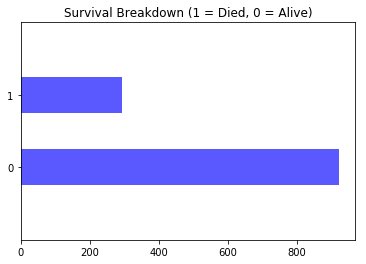

In [100]:
# Is death/alive case balanced?
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
LRG["Cancerdeath"].value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(LRG["Cancerdeath"].value_counts())) 
plt.title("Survival Breakdown (1 = Died, 0 = Alive)")

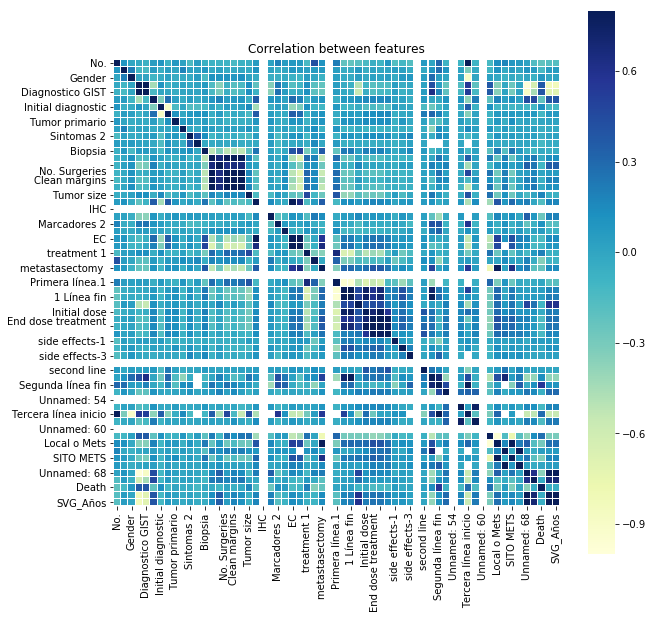

In [101]:
corr=LRG_test.corr()#["Survived"]
plt.figure(figsize=(10, 10))
import seaborn as sns
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=False,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

You can also see that this test cohort will have selecti bias and distribution difference compared to the training cohort.

# Acknowlegement
* First, thank our brave patients, wspecially these who gave all
* Thank Jimi and TA who put up this great class. You not only taught up new skills, but also taught us how to use. Thank you for give us a break so we can re-focus on machine learning not the final grade of machine learning class.